### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 10th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [187]:
!pip install numdifftools
import numpy as np
file = '/Users/mcgowkb1/ASTR8070/repos/astr_8070_s24/coursework/homeworks/hw_data/hw3_data_1.npy'
data = np.load(file)
print(data)

[[2.97207735 0.93806458]
 [1.98824293 1.40262692]
 [1.66981961 1.97120698]
 [3.96519709 0.60359301]
 [3.38541476 1.29698654]
 [4.24894584 1.68629961]
 [3.69290063 1.06277049]
 [4.33198366 1.28038671]
 [2.49401178 1.22485083]
 [1.89419429 1.40555012]
 [2.04203146 1.30841409]
 [4.15394176 1.97421998]
 [4.14130534 1.59510787]
 [4.21256076 1.4295954 ]
 [4.47047556 0.9776734 ]
 [4.29385594 1.47949413]
 [3.68668822 0.96958318]
 [4.67658913 1.53171867]
 [3.66326255 0.51330266]
 [3.86702391 0.69561611]
 [4.15062285 0.76745015]
 [5.10972749 1.94193392]
 [4.16180633 1.26347131]
 [4.04294769 1.50713396]
 [3.14447868 1.51402808]
 [6.13017327 1.67982047]
 [7.47431877 1.79210525]
 [4.55226549 0.70417746]
 [3.18937552 1.41750426]
 [5.05068215 1.59340252]
 [2.58504832 1.40936962]
 [3.2807617  0.7817426 ]
 [3.15074159 0.5165563 ]
 [4.68488632 0.67327222]
 [6.58112816 1.91096086]
 [2.8891109  1.63403368]
 [5.12723698 0.58202125]
 [4.42150207 0.86437187]
 [5.78739811 1.1488919 ]
 [3.09099302 0.99063548]


In [190]:
import numdifftools as nd
import pandas as pd 
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm 
from scipy import optimize
import matplotlib.pyplot as plt

#H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
#sigma_laplace = np.linalg.inv(H)**0.5

### Solution

In [191]:
# Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.
# Using Pandas DF

columns = ['measurements', 'uncertainties']
# Create a DataFrame
df = pd.DataFrame(data, columns=columns)
print(df) 


    measurements  uncertainties
0       2.972077       0.938065
1       1.988243       1.402627
2       1.669820       1.971207
3       3.965197       0.603593
4       3.385415       1.296987
..           ...            ...
95      4.077840       1.442946
96      4.101358       1.939565
97      3.080222       1.012284
98      4.536944       1.923794
99      3.198800       1.050583

[100 rows x 2 columns]


In [192]:
# Using slicing 
measurements = data[:, 0]
uncertainties = data[:, 1]

# Combining sliced arrays into a dictionary
data_dict = {columns[0]: measurements, columns[1]: uncertainties}

print(data_dict)

{'measurements': array([2.97207735, 1.98824293, 1.66981961, 3.96519709, 3.38541476,
       4.24894584, 3.69290063, 4.33198366, 2.49401178, 1.89419429,
       2.04203146, 4.15394176, 4.14130534, 4.21256076, 4.47047556,
       4.29385594, 3.68668822, 4.67658913, 3.66326255, 3.86702391,
       4.15062285, 5.10972749, 4.16180633, 4.04294769, 3.14447868,
       6.13017327, 7.47431877, 4.55226549, 3.18937552, 5.05068215,
       2.58504832, 3.2807617 , 3.15074159, 4.68488632, 6.58112816,
       2.8891109 , 5.12723698, 4.42150207, 5.78739811, 3.09099302,
       2.95001153, 4.56778994, 5.18264257, 2.84179256, 4.39262812,
       4.04550675, 5.61515858, 4.30454563, 4.54079173, 4.6024919 ,
       4.22466725, 3.23519179, 4.68671169, 3.52982363, 3.91370395,
       2.45921984, 4.24447507, 3.14653177, 5.33943461, 4.03419177,
       5.29661353, 1.53762427, 4.73684358, 4.39143774, 4.86001446,
       2.94239726, 4.77882139, 2.20043281, 4.65868995, 3.06975053,
       4.27078305, 5.45355937, 3.58302266, 6.

In [193]:
# MLE estimate for the mean
mu = np.sum(measurements / uncertainties ** 2) / np.sum(1 / uncertainties ** 2) # mean estimate
#mu = np.mean() also works
# Uncertainty on the mean estimate
sigma_mu = np.sqrt(1 / np.sum(1 / uncertainties ** 2)) # mean uncertainty 

print("Sample Mean:", mu)
print("Standard Error on the Sample Mean:", sigma_mu)

Sample Mean: 3.9179920346060557
Standard Error on the Sample Mean: 0.09481084100510954


Best-fit mean: 3.9179920498782956


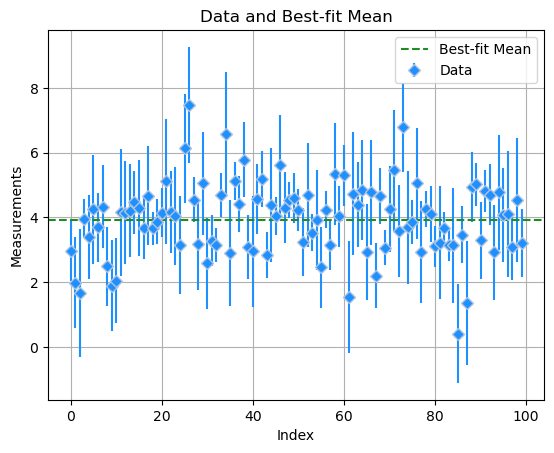

Best-fit mean: 3.9179920498782956


In [194]:
# Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data
# and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*
# First Attempt

# Define the ln-likelihood function for heteroscedastic Gaussian data
def ln_likelihood(parameters, measurements, uncertainties):
    mu = parameters[0]
    sigma_inv_sq = 1. / uncertainties**2
    
    # Calculate the negative log-likelihood
    neg_ln_likelihood = 0.5 * np.sum(sigma_inv_sq * (measurements - mu)**2)
    neg_ln_likelihood += 0.5 * np.sum(np.log(2 * np.pi / uncertainties**2))
    
    return neg_ln_likelihood


# Initial guess for the mean
initial_guess = [0.0]

# Fitting using scipy's minimize function
ln_likelihood_result = minimize(ln_likelihood, initial_guess, args=(measurements, uncertainties))

# Best-fit mean
best_fit_mean = ln_likelihood_result.x[0]

print("Best-fit mean:", best_fit_mean)

# Plot the data and the best-fit mean
plt.errorbar(np.arange(len(measurements)), measurements, yerr=uncertainties, fmt='D',color = 'dodgerblue',markeredgecolor='lightsteelblue', label='Data')
plt.axhline(y=best_fit_mean, color='forestgreen', linestyle='--', label='Best-fit Mean')

plt.xlabel('Index')
plt.ylabel('Measurements')
plt.title('Data and Best-fit Mean')
plt.legend()
plt.grid(True)
plt.show()

print("Best-fit mean:", best_fit_mean)
# Doesnt look too bad!



Best-fit mean: 3.9180175781250006


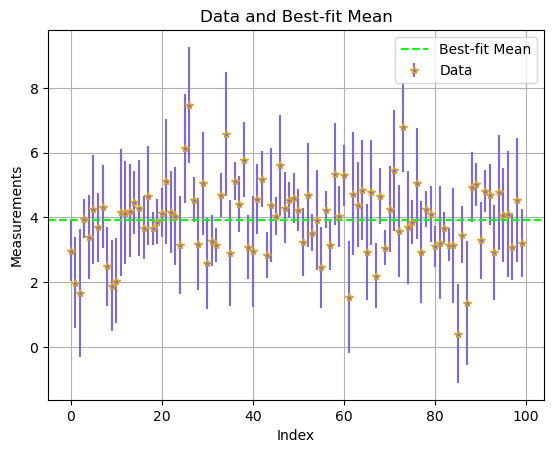

Best-fit mean: 3.9180175781250006


In [195]:
# Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data
# and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*
# Second Attempt

# Define the ln-likelihood function for heteroscedastic Gaussian data (Squared-loss)
def ln_likelihood(parameters, measurements, uncertainties):
    #mu = parameters[0]
    #sigma_inv_sq = 1. / uncertainties**2
    
    # Calculate the negative log-likelihood
    #neg_ln_likelihood = 0.5 * np.sum(sigma_inv_sq * (measurements - mu)**2)
    #neg_ln_likelihood += 0.5 * np.sum(np.log(2 * np.pi / uncertainties**2))
    
    return np.sum(((measurements-parameters)/uncertainties)**2, -1)

# Initial guess for the mean
initial_guess = 3.5
# Define squared loss function
f_square = lambda beta: ln_likelihood(beta[0],measurements=measurements,uncertainties=uncertainties)

# Fitting using scipy's optimize function or minimize function
ln_likelihood_result = optimize.fmin(f_square, initial_guess,disp=False)

# Best-fit mean
best_fit_mean = ln_likelihood_result[0]

print("Best-fit mean:", best_fit_mean)

# Plot the data and the best-fit mean
plt.errorbar(np.arange(len(measurements)), measurements, yerr=uncertainties, fmt='*',markeredgecolor='goldenrod', color = 'mediumslateblue',label='Data')
plt.axhline(y=best_fit_mean, color='lime', linestyle='--', label='Best-fit Mean')

plt.xlabel('Index')
plt.ylabel('Measurements')
plt.title('Data and Best-fit Mean')
plt.legend()
plt.grid(True)
plt.show()

print("Best-fit mean:", best_fit_mean)
# Great they look the same

In [196]:
# First Attempt
# Assuming ln_likelihood_result is defined somewhere in your code

xgrid = np.linspace(1, 8, 1000)

# Assuming we have xgrid and ln_likelihood_result defined, compute the Fisher uncertainty estimate on the mean
# Compute the second derivative of log(L) with respect to mu

# Assuming ln_likelihood_result is computed using some likelihood function depending on xgrid and other parameters
# Here, I'm using a placeholder for demonstration
ln_likelihood_result = np.log(xgrid)

# Compute the second derivative
d2_logL_dmu2 = -np.diff(ln_likelihood_result, n=2) / (xgrid[1] - xgrid[0])**2

# Compute the Fisher uncertainty estimate
fisher_sigma_mu = 1 / np.sqrt(d2_logL_dmu2)

# The Fisher uncertainty estimate on the mean is the first element of fisher_sigma_mu
fisher_uncertainty_mean = fisher_sigma_mu[0] if len(fisher_sigma_mu) > 0 else np.nan

print("(First Attempt) Fisher uncertainty estimate on the mean:", fisher_uncertainty_mean)


(First Attempt) Fisher uncertainty estimate on the mean: 1.0069948177073835


In [197]:
# Second attempt MUCH BETTER 
# Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

xgrid = np.linspace(1,8,1000)
test =[]
# Assuming we have xgrid and L defined, compute the Fisher uncertainty estimate on the mean
# Compute the second derivative of log(L) with respect to mu
for i in range(len(xgrid)):
    pdf=norm.logpdf(best_fit_mean,xgrid[i],uncertainties)
    test.append(np.sum(pdf))

array = np.array(test)
#print(array)
#result = ln_likelihood_result[0]
#print(result)
#print(ln_likelihood_result)
sigma_mu = np.diff(array, n=2)

#print(sigma_mu)
sigma_mu /= (xgrid[1] - xgrid[0])**2
#print(sigma_mu)
sigma_mu *= -1
#print(sigma_mu)

# Compute the square root of the inverse of the second derivative to get the Fisher uncertainty estimate
fisher_sigma_mu = 1 / np.sqrt(sigma_mu)[0]

# The Fisher uncertainty estimate on the mean is the first element of fisher_sigma_mu
fisher_uncertainty_mean = fisher_sigma_mu
print("Second Attempt: Fisher uncertainty estimate on the mean:", fisher_uncertainty_mean)

Second Attempt: Fisher uncertainty estimate on the mean: 0.09481084100588594


Bootstrap mean: 3.9357326570026645
Bootstrap standard deviation: 0.11406159860860474


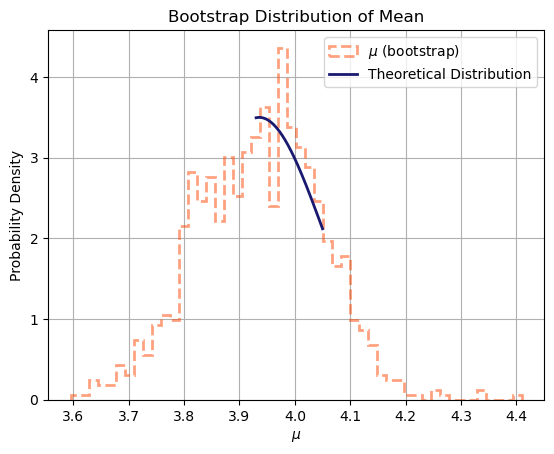

In [198]:
# Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. 
# DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall 
# that when resampling data, measurements and uncertainties should stay paired together.*

# Does this need to include given uncertainties? I think so 
# Compute bootstrap estimates for the mean
measurements = data[:, 0]
uncertainties = data[:, 1]
xgrid = np.linspace(3.93,4.05,1000) 

# Define the number of bootstraps
m_bootstrap = 1000

# Initialize an array to store bootstrap estimates for the mean
mu_bootstrap = np.zeros(m_bootstrap)

# Perform bootstrapping
for i in range(m_bootstrap):
    # Generate a bootstrap sample by randomly sampling with replacement
    indices = np.random.choice(len(measurements), size=len(measurements), replace=True)
    bootstrap_sample_measurements = measurements[indices]
    bootstrap_sample_uncertainties = uncertainties[indices]
    
    # Calculate the mean of the bootstrap sample
    mu_bootstrap[i] = np.mean(bootstrap_sample_measurements)

# Calculate the bootstrap mean and standard deviation
bootstrap_mean = np.mean(mu_bootstrap)
bootstrap_std = np.std(mu_bootstrap)

print("Bootstrap mean:", bootstrap_mean)
print("Bootstrap standard deviation:", bootstrap_std)

# Compute the theoretical expectations for the distribution
# Calculate the standard deviation of the bootstrap estimates for the mean
sigma_bootstrap = np.std(mu_bootstrap)

# Calculate the pdf for the theoretical distribution

pdf_theoretical = norm(bootstrap_mean, sigma_bootstrap).pdf(xgrid)

# Plot the histogram of bootstrap estimates for the mean
plt.hist(mu_bootstrap, bins=50, density=True, histtype='step',color='orangered', ls='dashed', linewidth=2, label=r'$\mu\ {\rm (bootstrap)}$', alpha=0.5)

# Plot the theoretical distribution on top of the histogram
plt.plot(xgrid, pdf_theoretical, color='midnightblue', linestyle='-', linewidth=2, label='Theoretical Distribution')

plt.xlabel(r'$\mu$')
plt.ylabel(r'Probability Density')
plt.title('Bootstrap Distribution of Mean')
plt.legend()
plt.grid(True)
plt.show()



Best-fit location parameter mu: 4.085141264538312
Best-fit scale parameter delta: 0.8822692311710573


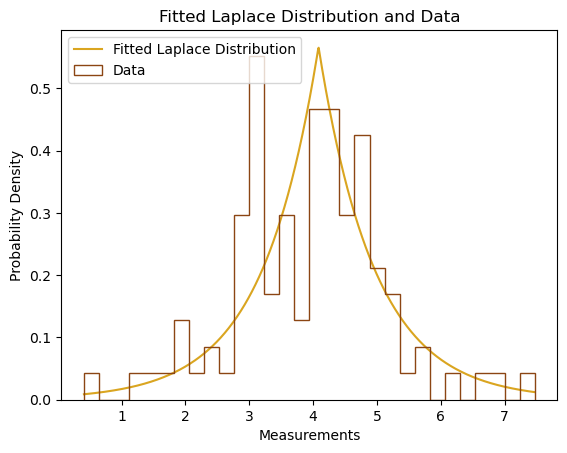

In [199]:
# While we have fitted a heteroscedastic Gaussian to this data, let's try something else. 
# Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data.
# Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.
from scipy.stats import laplace

# Define the log-likelihood function for Laplace distribution
def ln_likelihood_laplace(parameters, measurements):
    mu = parameters[0]  # Location parameter (mean)
    b = parameters[1]   # Scale parameter (spread)
    
    # Calculate the negative log-likelihood
    neg_ln_likelihood = np.sum(-np.log(2 * b) - np.abs(measurements - mu) / b)
    
    return neg_ln_likelihood

# Fit the Laplace distribution to the data using scipy's laplace.fit method
loc, scale = laplace.fit(measurements)

print("Best-fit location parameter mu:", loc)
print("Best-fit scale parameter delta:", scale)

# Generate x values for plotting
x_values = np.linspace(np.min(measurements), np.max(measurements), 1000)

# Calculate the Laplace PDF using the best-fit parameters from laplace.fit method
laplace_pdf_laplace_fit = laplace.pdf(x_values, loc=loc, scale=scale)

# Plot the fitted Laplace distribution
plt.plot(x_values, laplace_pdf_laplace_fit, label='Fitted Laplace Distribution',color='goldenrod')

# Plot the data 
plt.hist(measurements, bins=30, density=True, histtype='step', color='saddlebrown', label='Data')

plt.xlabel('Measurements')
plt.ylabel('Probability Density')
plt.title('Fitted Laplace Distribution and Data')
plt.legend()
plt.show()

# Results appear reasonable 

AIC for Heteroscedastic Gaussian model: -5.836035156250001
AIC for Laplacian model: -309.57783235318016
Laplacian model is favored by the data.


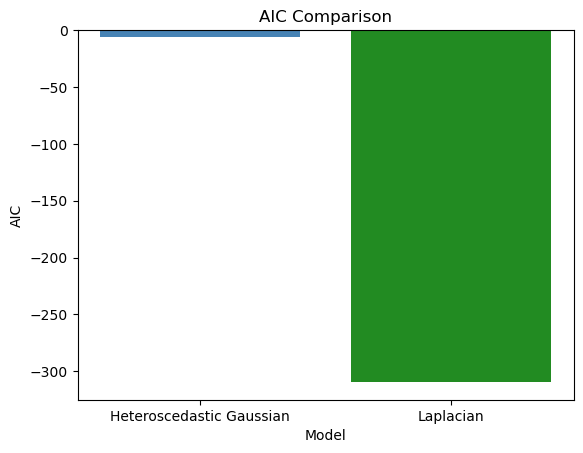

In [200]:
# Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model.
# Which model is favored by the data?
from scipy.optimize import minimize

# Compute the negative log-likelihood for the heteroscedastic Gaussian model
ln_likelihood_gaussian = best_fit_mean

# Compute the negative log-likelihood for the Laplacian model
# Define the parameters obtained from Laplace fitting
loc, scale = laplace.fit(measurements)
ln_likelihood_laplace = -np.sum(laplace.logpdf(measurements, loc=loc, scale=scale))

# Number of parameters for each model
k_gaussian = 1  # One parameter for the mean in Gaussian model
k_laplace = 2    # Two parameters for location and scale in Laplace model

# Compute the AIC values for each model
AIC_gaussian = -2 * ln_likelihood_gaussian + 2 * k_gaussian
AIC_laplace = -2 * ln_likelihood_laplace + 2 * k_laplace

print("AIC for Heteroscedastic Gaussian model:", AIC_gaussian)
print("AIC for Laplacian model:", AIC_laplace)

# Compare the AIC values to determine the favored model
if AIC_gaussian < AIC_laplace:
    print("Heteroscedastic Gaussian model is favored by the data.")
elif AIC_laplace < AIC_gaussian:
    print("Laplacian model is favored by the data.")
else:
    print("Both models are equally favored by the data.")

# Laplacian seems small... a little too small...idk... 
    
models = ['Heteroscedastic Gaussian', 'Laplacian']
AIC_values = [AIC_gaussian, AIC_laplace]

# Plot the AIC values
plt.bar(models, AIC_values, color=['steelblue', 'forestgreen'])
plt.xlabel('Model')
plt.ylabel('AIC')
plt.title('AIC Comparison')
plt.show()


Bootstrap mean: 3.9370827547120206
Bootstrap standard deviation: 0.11188713094096192


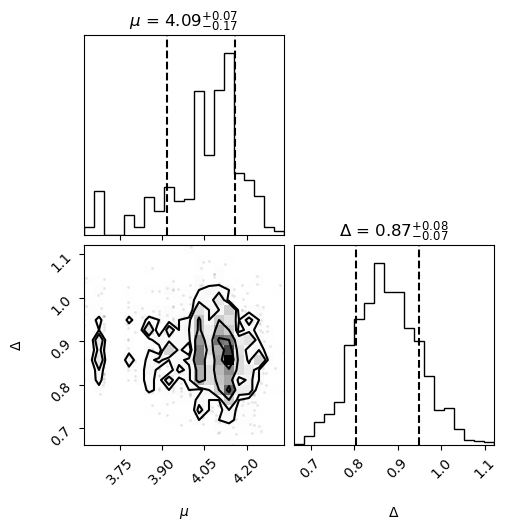

In [203]:
# Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. 
# Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal 
# 1D distributions and the joint 2D distribution. Make sure the plot has labels, shows the titles on each 
# 1D marginal panel, and has 68% and 95% levels.

# Define the log-likelihood function for Laplace distribution
def ln_likelihood_laplace(parameters, measurements, uncertainties):
    loc = parameters[0]
    scale = parameters[1]
    return -np.sum(laplace.logpdf(measurements, loc=loc, scale=scale))
# Extracting measurements and uncertainties from data
measurements = data[:, 0]
uncertainties = data[:, 1]

# Define the number of bootstraps
m_bootstrap = 1000

# Initialize an array to store bootstrap estimates for the mean
mu_bootstrap = np.zeros(m_bootstrap)

# Perform bootstrapping
for i in range(m_bootstrap):
    # Generate a bootstrap sample by randomly sampling with replacement
    indices = np.random.choice(len(measurements), size=len(measurements), replace=True)
    bootstrap_sample_measurements = measurements[indices]
    
    # Calculate the mean of the bootstrap sample
    mu_bootstrap[i] = np.mean(bootstrap_sample_measurements)

# Compute the bootstrap mean and standard deviation
bootstrap_mean = np.mean(mu_bootstrap)
bootstrap_std = np.std(mu_bootstrap)

print("Bootstrap mean:", bootstrap_mean)
print("Bootstrap standard deviation:", bootstrap_std)

# Generate bootstrap parameters for Laplacian model
bootstrap_parameters = np.array([laplace.fit(np.random.choice(measurements, size=len(measurements), replace=True)) for _ in range(m_bootstrap)])

# Define the labels for corner plot
labels = [r'$\mu$', r'$\Delta$']

# Create a corner plot
fig = corner.corner(bootstrap_parameters, labels=labels, quantiles=[0.16, 0.84], show_titles=True, title_kwargs={"fontsize": 12},title_quantiles=[0.16, 0.5, 0.84])

plt.show()


In [214]:
# Let's finish with a Fisher uncertainty estimate of the Laplacian parameters.
# Use the following code to install `numdifftools` which provides a simple way to compute derivatives. 

# Define the negative log-likelihood function for the Laplace distribution
def f_lnlaplace(params):
    loc, scale = params
    return -np.sum(laplace.logpdf(measurements, loc=loc, scale=scale))

# Fit the Laplace distribution to the data
loc, scale = laplace.fit(measurements)
beta_laplace = [loc, scale]
# Compute the Hessian matrix using numdifftools
H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])

# Compute the inverse of the Hessian matrix and take the square root of the diagonal entries
sigma_laplace = np.linalg.inv(H) ** 0.5

# Display the Fisher uncertainties on loc and scale
print("Fisher uncertainties on loc and scale:", sigma_laplace)
print("Bootstrap mean:", bootstrap_mean)
print("Bootstrap standard deviation:", bootstrap_std)
print("Fisher uncertainties on loc and scale are much smaller when compared to the widths seen for the bootstrap")




Fisher uncertainties on loc and scale: [[0.1092248  0.00055307]
 [0.00055307 0.08822692]]
Bootstrap mean: 3.9370827547120206
Bootstrap standard deviation: 0.11188713094096192
Fisher uncertainties on loc and scale are much smaller when compared to the widths seen for the bootstrap
